# CS 4496/7496 Character Animation (Fall 2021)
Copyright (c) Georgia Institute of Technology

---


# Homework 1: Keyframe Interpolation (due 9/24/2021, 11:59PM)

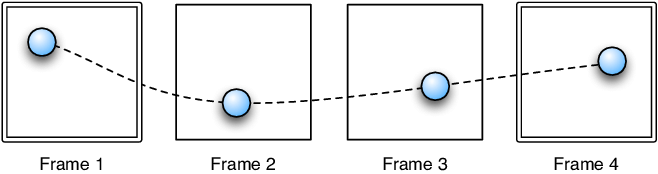

In this project, you will write code snippets to demonstrate three different types of interpolation - Bezier Curve, B-Spline (with de Boor points), and Catmull-Rom. Why are splines important? We can use those splines for describing most aspects of animation, including motions or geometry.




Let's start with the example of linear splines.
Our goal is to generate the linear interpolation of the predefined control points. The below contains three example keyframes out of total 10 keyframes (points). There x axis value is uniformly set to [0, 1, ..., 9], but they can be any values.

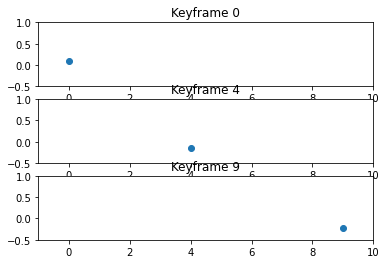

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

num_dimensions = 2
num_points = 10
control_points = np.zeros((num_points, num_dimensions))
control_points[:, 0] = np.linspace(0.0, num_points - 1, num_points)  # X points = [0.0, 1.0, 2.0, ..., ]
control_points[:, 1] = [np.random.uniform(-1.0, 1.0) for i in range(num_points)]  # Y points are randomly sampled between (-1.0, 1.0)
frame_indices = [0, 4, 9]
fig, ax_array = plt.subplots(len(frame_indices), 1)
for ax_index, frame in enumerate(frame_indices):
  ax_array[ax_index].scatter(control_points[frame:frame + 1, 0], control_points[frame:frame + 1, 1])
  ax_array[ax_index].set_title('Keyframe %d' % frame)
  ax_array[ax_index].set_xlim(-1.0, 10.0);
  ax_array[ax_index].set_ylim(-0.5, 1.0);

For brevity, we will overlay all the figures to one figure.

(-1.0, 10.0)

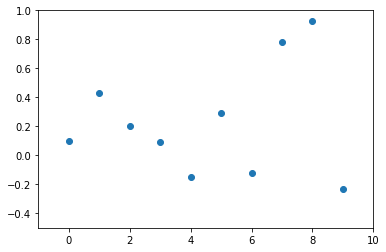

In [3]:
plt.scatter(control_points[:, 0], control_points[:, 1]); plt.ylim(-0.5, 1.0); plt.xlim(-1.0, 10.0)

The below is a helper function for unit tests. Do not modify this.

In [4]:
# Unit test
def unit_test_fn(func):
    _control_points_test = np.zeros((4,2))
    _control_points_test[:, 0] = np.linspace(0.0, 3.0, 4)
    _control_points_test[:, 1] = [0.9819, 0.2035, 0.5105, 0.2076]
    _sample_t = [0.29, 0.77, 0.89, 0.91, 0.98]
    arg_list = [_control_points_test[i] for i in range(_control_points_test.shape[0])]
    result_list = [func(*arg_list,t) for t in _sample_t]
    result = np.array(result_list)
    if func.__name__=='bezier_interpolation_at_t':
        ans = np.array(
        [[0.87,      0.53719175],
         [2.31,      0.34043659],
         [2.67,      0.28767407],
         [2.73,      0.2757983 ],
         [2.94,      0.22505568]])
    elif func.__name__=='bspline_interpolation_at_t':
        ans = np.array(
        [[1.29,      0.35479696],
         [1.77,      0.39568443],
         [1.89,      0.40531068],
         [1.91,      0.40640138],
         [1.98,      0.40868928]]
        )
    elif func.__name__=='catmullrom_interpolation_at_t':
        ans = np.array(
        [[1.29,      0.2314021 ],
         [1.77,      0.45936932],
         [1.89,      0.49745626],
         [1.91,      0.50159738],
         [1.98,      0.51000474]]
        )
    else:
        return
    assert np.allclose(ans, result, 1e-6), 'function '+ \
        func.__name__+' does not pass unit test'

The most intuitive approach is linear interpolation. The below example function returns a point that linearly interpolates two points, p0 and p1, at time t. The time t is assumed to be between 0 and 1.

In [5]:
def linear_interpolation_at_t(p0, p1, t):
  """
  Returns the linear interpolation of two points at time t.

  Args:
    p0: the point at t = 0 (np.array).
    p1: the point at t = 1 (np.array).
    t: the given time for interpolation.
  """
  assert 0 <= t <= 1  # what if we do not have this assertion?
  return (1 - t) * p0 + t * p1

Then we can write a complete linear interpolation function on top of the helper function (linear_interpolation_at_t). For each adjacent pair of control points, we will sample the in-between points by repetitively calling the interpolation function with t = 0.0, t = 0.01, t = 0.02, and so on. 

In [6]:
def linear_interpolation_of_points(control_points):
  """
  Returns the linear interpolation of control points.

  Args:
    control_points: a list of points (np.array) that defines a spline.
  """
  interpolated_points = list()  # The container for interpolated points
  time_array = np.linspace(0.0, 1.0, 101)  # time[0] = 0.0, time[1] = 0.01, ... time[100] = 1.0

  # For each pair of control points
  for p0, p1 in zip(control_points[:-1], control_points[1:]):
    # Compute the interpolated points and append to the list
    points = [linear_interpolation_at_t(p0, p1, t) for t in time_array]
    interpolated_points += points
  
  return np.array(interpolated_points)

Let's verify the results by visualizing the spline and control points. Can you see the red linear spline that interpolates blue control points? If not, please contact instructors.

Text(0.5, 0, 'time')

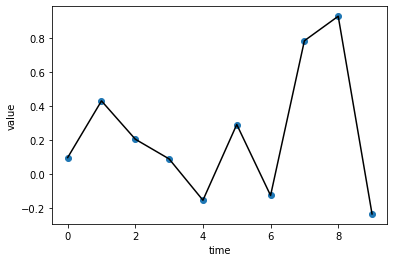

In [7]:
linear_points = linear_interpolation_of_points(control_points)
plt.plot(linear_points[:, 0], linear_points[:, 1], 'k')
plt.scatter(control_points[:, 0], control_points[:, 1])
plt.ylabel('value'); plt.xlabel('time')

# 1. Bezier Curves
Alright. It is time to write your own code to generate Bezier curves. Write your own function below. (hint: start with constructing the time matrix T, the basis matrix M, and the geometry matrix G). ** **write your code below (30 pts)**  ** 

** **Note from the instructor: please document the code as much as possible, just in case** **

In [1]:
def bezier_interpolation_at_t(p0, p1, p2, p3, t):
  """All the points are given as np.array. t is a floating number that represents time."""
  # Student answer begins
  assert 0 <= t <= 1 
  T = np.array([t**3, t**2, t, 1]) #time matrix T
  M = np.array([[-1,3,-3,1], [3,-6,3,0], [-3,3,0,0], [1,0,0,0]]) #basis matrix M
  G = np.array([p0,p1,p2,p3]) #geometry matrix G
  return np.dot(np.dot(T,M), G) #T*M*G
  # Student answer ends

Then we also need a full interpolation function for cubic splines. We will extend the above linear_interpolation_of_points function to support cubic splines. We create multiple Bezier curves by grouping four points together, like [0, 1, 2, 3], [3, 4, 5, 6], and so on.

In [8]:
def bezier_interpolation_of_points(control_points):
  """control_points is a list of points (np.array)."""
  interpolated_points = list()
  time_array = np.linspace(0.0, 1.0, 101)  # time[0] = 0.0, time[1] = 0.01, ... time[100] = 1.0
  for i in range(0, len(control_points) - 3, 3):
    p0, p1, p2, p3 = control_points[i:i + 4]
    points = [bezier_interpolation_at_t(p0, p1, p2, p3, t) for t in time_array]
    interpolated_points += points
  return np.array(interpolated_points)

The visualization is straightforward. We will also do a unit test.

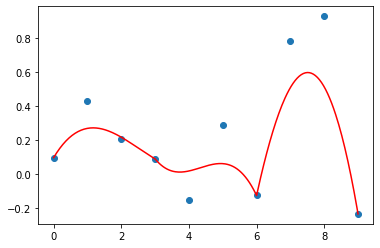

In [9]:
bezier_points = bezier_interpolation_of_points(control_points)
assert isinstance(bezier_points, np.ndarray), 'bezier_points should be numpy array'
plt.plot(bezier_points[:, 0], bezier_points[:, 1], 'r')
plt.scatter(control_points[:, 0], control_points[:, 1])
# Unit test
unit_test_fn(bezier_interpolation_at_t)
assert bezier_points.shape == (303, 2), 'berizer_points has incorrect shape' 

# 2. B-Splines
The next is B-spline, which is defined by de Boor points. You can find its definition in the lecture slides. Once again, we will start with writing the helper function, and then implement the full function. Note that the indices of de Boor points increase by one, not three: [0, 1, 2, 3], [1, 2, 3, 4], and so on. ** **write your code below (30 pts)** **

In [10]:
def bspline_interpolation_at_t(p0, p1, p2, p3, t):
  """All the points are given as np.array. t is a floating number that represents time."""
  # Student answer begins
  T = np.array([t**3, t**2, t, 1]) #time matrix T
  M = np.array([[-1,3,-3,1], [3,-6,3,0], [-3,0,3,0], [1,4,1,0]]) #basis matrix M
  G = np.array([p0,p1,p2,p3]) #geometry matrix G
  return (1/6) * np.dot(np.dot(T,M), G) #(1/6) * T * M * G
  # Student answer ends

def bspline_interpolation_of_points(control_points):
  """control_points is a list of points (np.array)."""
  interpolated_points = list()
  time_array = np.linspace(0.0, 1.0, 101)  # time[0] = 0.0, time[1] = 0.01, ... time[100] = 1.0
  for i in range(0, len(control_points) - 3, 1):
    p0, p1, p2, p3 = control_points[i:i + 4]
    points = [bspline_interpolation_at_t(p0, p1, p2, p3, t) for t in time_array]
    interpolated_points += points
  return np.array(interpolated_points)

Then the visualization is straight-forward.

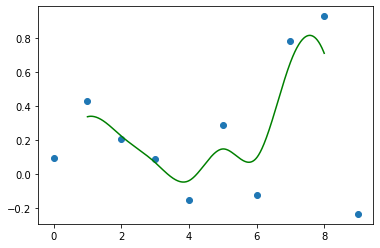

In [11]:
bspline_points = bspline_interpolation_of_points(control_points)
assert isinstance(bspline_points, np.ndarray), 'bspline_points should be numpy array'
plt.plot(bspline_points[:, 0], bspline_points[:, 1], 'g')
plt.scatter(control_points[:, 0], control_points[:, 1])
# Unit test
unit_test_fn(bspline_interpolation_at_t)
assert (bspline_points.shape == (707, 2) or bspline_points.shape ==
        (1111, 2)), 'bspline_points has incorrect shape'

# 3. Catmull-Rom spline
The final is a Catmull-Rom spline. As always, we will implement both the helper and full interpolation functions. Once again, control point indices will increase one by one. ** **write your code below (30 pts)** **

In [12]:
def catmullrom_interpolation_at_t(p0, p1, p2, p3, t):
  """All the points are given as np.array. t is a floating number that represents time."""
  # Student answer begins  
  T = np.array([t**3, t**2, t, 1]) #time matrix T
  M = np.array([[-1,3,-3,1], [2,-5,4,-1], [-1,0,1,0], [0,2,0,0]]) #basis matrix M
  G = np.array([p0,p1,p2,p3]) #geometry matrix G
  return (1/2) * np.dot(np.dot(T,M), G) #T*M*G
  # Student answer ends

def catmullrom_interpolation_of_points(control_points):
  """control_points is a list of points (np.array)."""
  interpolated_points = list()
  time_array = np.linspace(0.0, 1.0, 101)  # time[0] = 0.0, time[1] = 0.01, ... time[100] = 1.0
  for i in range(0, len(control_points) - 3, 1):
    p0, p1, p2, p3 = control_points[i:i + 4]
    points = [catmullrom_interpolation_at_t(p0, p1, p2, p3, t) for t in time_array]
    interpolated_points += points
  return np.array(interpolated_points)

Let's repeat the same procedure for visualization.

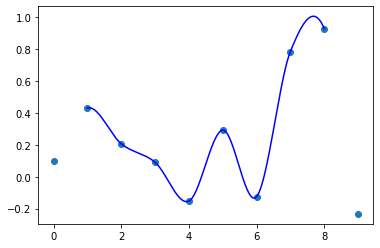

In [13]:
catmullrom_points = catmullrom_interpolation_of_points(control_points)
assert isinstance(catmullrom_points, np.ndarray), 'catmullrom_points should be numpy array'
plt.plot(catmullrom_points[:, 0], catmullrom_points[:, 1], 'b')
plt.scatter(control_points[:, 0], control_points[:, 1])
# Unit test
unit_test_fn(catmullrom_interpolation_at_t)
assert (catmullrom_points.shape == (707, 2) or catmullrom_points.shape == (
    909, 2)), 'catmullrom_points has incorrect shape'

Based on your observation, discuss the three properties (continuity, interpolation, and local control) of Bezier curves.

As shown in the Bezier curve plot, the Bezier curves are continuous, but they do not interpolate every control point. Also, they do not have local control as moving a single control point affects not just the area around that point but the entire curve.

# 4. Discussion
Now let's take a look at all the results in one plot. We can simply plot everything all together.

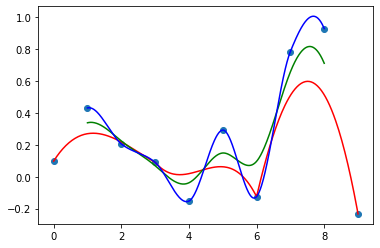

In [14]:
plt.plot(bezier_points[:, 0], bezier_points[:, 1], 'r')
plt.plot(bspline_points[:, 0], bspline_points[:, 1], 'g')
plt.plot(catmullrom_points[:, 0], catmullrom_points[:, 1], 'b')
plt.scatter(control_points[:, 0], control_points[:, 1])

We will also animate them.

generating the frame 0
generating the frame 0
generating the frame 10
generating the frame 20
generating the frame 30
generating the frame 40


generating the frame 0


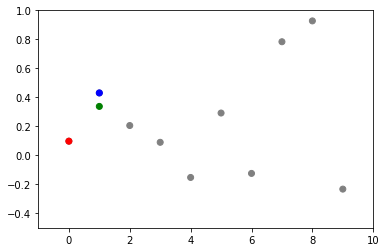

In [15]:
from matplotlib import rc
rc('animation', html='jshtml')

from math import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation

fig = plt.figure()
ax = plt.axes()
num_frames = 50

def frame(w):
    if w % 10 == 0:
      print('generating the frame %d' % w)
    ax.clear()
    global num_frames
    global bezier_points
    global bspline_points
    global control_points
    global catmullrom_points
    bezier_index = len(bezier_points) // num_frames * w
    bspline_index = len(bspline_points) // num_frames * w
    catmullrom_index = len(catmullrom_points) // num_frames * w
    x = [bezier_points[bezier_index, 0], bspline_points[bspline_index, 0], catmullrom_points[catmullrom_index, 0]]
    y = [bezier_points[bezier_index, 1], bspline_points[bspline_index, 1], catmullrom_points[catmullrom_index, 1]]
    x = list(control_points[:, 0]) + x
    y = list(control_points[:, 1]) + y
    c = ['grey'] * control_points.shape[0] + ['r', 'g', 'b'] 
    plot = ax.scatter(x, y, c=c)
    ax.set_xlim(-1.0, 10.0)
    ax.set_ylim(-0.5, 1.0)
    return plot

anim = animation.FuncAnimation(fig, frame, frames=num_frames, blit=False, repeat=True)
anim

Can you see all three splines and their animations? Please discuss the properties of the rendered splines, particularly about their continuity, interpolation, and local control. ** **write your answer below (10 pts)** **



```
# This is formatted as code
```

I can see all three splines and their animations. As discussed in the previous question, the Bezier curves are continous but not interpolated as there exist some control points that they do not pass through, and they also do not have local control. 
Similar to the Bezier curves, the B-splines are continous, and they do not interpolate the control points as they do not pass through all control points. The B-splines, on the other hand, have local control as moving a control point does not affect the whole curve but only the defined area around that moved point.  
Lastly, although the Catmull-Rom splines do not have C2 continuity, they interpolate every control point and have local control. 

# 5. Extra Questions

5.1. Make b-spline start and end at the first and last de Boor points. Please visualize the result at the end. ** **write your code below (3 pts)** ** 





In [ ]:
def bspline_interpolation_of_points_v2(control_points):
  pass

5.2. Implement a C2-interpolating curve and visualize it. ** **write your code below (3 pts)** **

In [ ]:
def c2_interpolation_of_points(control_points):
  pass

5.3. Splines are often used for describing animations of characters. Using your favorite spline, generate an interesting gesture (e.g., dance, hello, ...) of a X-arm manipulation robot. Skeleton codes will be given. ** **write your code below (4 pts)** ** 

In [ ]:
%%time
!apt-get install -y xvfb python-opengl ffmpeg
!pip install pybullet==2.6.5
!pip install ffmpeg-python

In [ ]:
import pybullet as p
import pybullet_data as pd
import numpy as np
import random
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

import cv2
from PIL import Image
import ffmpeg

# Initialize PyBullet 
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pd.getDataPath())

p.resetSimulation()
useFixedBase = True
flags = p.URDF_INITIALIZE_SAT_FEATURES

plane = p.loadURDF("plane.urdf", [0, 0, -0.625], flags = flags, useFixedBase=True)
table = p.loadURDF("table/table.urdf", [0, 0, -0.625], flags = flags, useFixedBase=True)
xarm = p.loadURDF("xarm/xarm6_robot.urdf", flags = flags, useFixedBase=True)
num_xarm_joints = p.getNumJoints(xarm)

# Initialize Camera
pixelWidth = 640
pixelHeight = 360
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0.2], 
                                                 distance=1.1, 
                                                 yaw=0.0, 
                                                 pitch=-10.0, 
                                                 roll=0.0, 
                                                 upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov=60, 
                                                aspect=pixelWidth / pixelHeight, 
                                                nearVal=0.01, 
                                                farVal=100)

# Main loop that renders 100 frames
for t in range(100):
  # This code sets the robot's joint angles for each frame.
  for j in range(num_xarm_joints):
    # (TODO) Edit here to describe your own animation.
    # xarm is the robot
    # j is the joint index
    # i * 0.01 is the joint angle, which is current set to a manual function f(t) = 0.01 * t. Please replace this with your spline.
    p.resetJointState(xarm, j, t * 0.01) 

  # Render images
  _, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1,1,1])
  Image.fromarray(img[:, :, :3]).save('./frame%04d.jpg' % t)

def show_gif_image(filename):
  video = io.open(filename, 'r+b').read()
  encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<img src="data:image/gif;base64,{0}"/>'''.format(encoded.decode('ascii'))))

# Zip the animation in to gif
ffmpeg.input('./frame*.jpg', pattern_type='glob', framerate=20.0).output('./output.gif').overwrite_output().run()
show_gif_image('./output.gif')

# 6. Research Project.
Please develop an interactive tool that you can create/modify splines lively. For instance, the tool allows a user to create a point by clicking a workspace, modify their locations with dragging, interpolate them with different splines,and play the animation. You can be creative about the functionality. 

**Userful Links:**
You can use your favorite tool for this project. If you are not sure, you may want to look in to some python GUI packages, such as PyQt5, Pygame, or ModernGL. Or, you can use some interactive tools, such as Processing, if you are familiar with. Some animation tools, such as Blender or Maya, can be a source of inspiration.

**Deliverable:**
Please submit the code, the short document (e.g., how to run or how to use) and the demo video in a zip file. Please write down the downloadable link to the cell below.

**Points:**
10 additional points, but the sum of the extra question points and research project points will not exceed 10 points.


(please write the link here).